In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import joblib
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
import os

%load_ext autoreload
%autoreload 2
%matplotlib notebook
# %matplotlib inline

In [2]:
# body_part = "head"
# file_names = ['./training_data/head_data_1.log',
#              './training_data/head_data_2.log',
#              './training_data/head_data_3.log',
#              './training_data/head_data_4.log',
#              './training_data/head_data_5.log',
#              './training_data/head_data_6.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data_old/shoulder_right_data_1.log',
#              './training_data_old/shoulder_right_data_2.log',
#              './training_data_old/shoulder_right_data_3.log',
#              './training_data_old/shoulder_right_data_4.log',
#              './training_data_old/shoulder_right_data_5.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data/shoulder_right_train_10_17.log',
#              './training_data_old/shoulder_right_data_6.log',
#              './training_data_old/shoulder_right_data_7.log',
#              './training_data_old/shoulder_right_data_8.log',
#              './training_data_old/shoulder_right_data_9.log',
#             ]

body_part = "shoulder_left"
file_names = [
    './training_data/val_fb_sfast_dvbf_medium.bag']

# file_names = ['./training_data/shoulder_left_5.log',
#               './training_data/shoulder_left_6.log',
#               './training_data/shoulder_left_7.log']

# body_part = "shoulder_left"
# file_names = ['./training_data/shoulder_left_1.log',
#               './training_data/shoulder_left_2.log',
#               './training_data/shoulder_left_3.log']

In [3]:
# orig_dataset = pd.concat([pd.read_csv(f, header=0) for f in file_names])
# orig_dataset = orig_dataset.values[1:len(orig_dataset)-2,1:]

abnormal_threshold = 0.5
dataset = []
orig_dataset = []

euler_idxs = ["position_0", "position_1", "position_2"]
# action_idxs = ["cf_velocity_0", "cf_velocity_1", "cf_velocity_2"]
action_idxs = ["target_position_0", "target_position_1", "target_position_2"]
magnetic_idxs = [f'{coord}_{id}' for id in range(4) for coord in ['x','y','z']]

for name in file_names:
    df = pd.read_csv(name, header=0)
    
#     df['date'] = pd.to_datetime(df.Time, unit='s')
#     df.groupby(pd.Grouper(key='date', freq='20L')).mean().interpolate()

    orig_dataset.append(df.copy())
    
    # interpolate nan outputs (loss tracking)
    for c in euler_idxs:
        df[c] = df[c].interpolate()
    
    # interpolate abnormal inputs
#     for c in magnetic_idxs:
#         bad_idx = df.index[df[c].pct_change().abs().ge(abnormal_threshold)]
#         df.loc[bad_idx, c] = np.nan
#         df[c] = df[c].interpolate()
    
#     # Add action
#     for c in df.columns[-3:]:
#         df["dt"] = (df["Time"][1:].tolist() - df["Time"][:-1])
#         df[c + "_u"] = (df[c][1:].tolist() - df[c][:-1]) / df["dt"]
    
#     # Remove last row
#     df = df[:-1]
    dataset.append(df)

dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset) 
orig_dataset = pd.concat(orig_dataset)

print(f'{np.sum(dataset_len)} values')

dataset = dataset[["Time"] + magnetic_idxs + euler_idxs + action_idxs].values[:,1:]
orig_dataset = orig_dataset[["Time"] + magnetic_idxs + euler_idxs + action_idxs].values[:,1:]

# dataset = dataset[abs(dataset[:,12])!=0.0,:]
# dataset = dataset[abs(dataset[:,13])!=0.0,:]
# dataset = dataset[abs(dataset[:,14])!=0.0,:]

# print(f'{len(dataset)} values after filtering outliers')

euler_set = dataset[:, 12:15]
action_set = dataset[:, 15:]
sensors_set = dataset[:, :12]
orig_sensors_set = orig_dataset[:, :12]
print(f'max euler {str(np.amax(euler_set))}')
print(f'min euler {str(np.amin(euler_set))}')

15047 values
max euler 0.4048930652052869
min euler -2.039221058094067


In [4]:
len(orig_dataset), len(dataset)

(15047, 15047)

In [5]:
dataset_len

[15047]

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from libs.orientation_utils import compute_rotation_matrix_from_euler, compute_ortho6d_from_rotation_matrix, compute_rotation_matrix_from_ortho6d, compute_euler_angles_from_rotation_matrices

In [7]:
euler_set_in = np.zeros_like(euler_set)
euler_set_in[:, 0] = euler_set[:, 2] 
euler_set_in[:, 1] = euler_set[:, 1] 
euler_set_in[:, 2] = euler_set[:, 0] 

euler_set = torch.Tensor(euler_set_in).cuda()
rot_set = compute_rotation_matrix_from_euler(euler_set)
rot_set = compute_ortho6d_from_rotation_matrix(rot_set).cpu().detach().numpy()

In [8]:
model_path = f"./outputs_idp/local_{body_part}_dvbf_long_trajs_ad_with_target_rot6D"

sensors_scaler, action_scaler = joblib.load(f'{model_path}/scaler.pkl')

# Split magnetic sensors into 4 independent distributions again
orig_sensors_set = sensors_scaler.transform(orig_sensors_set).reshape(-1, 4, 3)
sensors_set = sensors_scaler.transform(sensors_set).reshape(-1, 4, 3)
action_set = action_scaler.transform(action_set)

In [9]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from libs.data_modules import SensorsDataModule
from libs.nn_models import mse_seq
from libs.dvbf_models import DVBF

In [10]:
look_back = 10

data_in = []
data_u = []
data_hat_in = []
data_out = []

start_idx = 0
for l in dataset_len:
    # Ignore the last batch
    for i in range(start_idx, start_idx+l-look_back*2):
        data_in.append(orig_sensors_set[i:i+look_back])
        data_hat_in.append(sensors_set[i:i+look_back])
        data_u.append(action_set[i:i+look_back])
        data_out.append(rot_set[i+1:i+look_back+1])
    print(len(data_in))
    start_idx += l

15027


In [11]:
with open(f'{model_path}/hyperparams.json', 'r') as fp:
    p = json.load(fp)

In [12]:

dm = SensorsDataModule(
    data_x = data_in,
#     data_x = data_hat_in,
    data_u = data_u,
    data_y = data_out,
    data_x_hat = data_hat_in,
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)

In [13]:
model = DVBF.load_from_checkpoint(checkpoint_path=f"{model_path}/best-epoch=9889-val_loss=-233.49173.ckpt")

/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [14]:
# device = "cuda"
device = "cpu"
model.to(device)
torch.set_grad_enabled(False)
model.eval()

DVBF(
  (initial_lstm): LSTM(12, 100, batch_first=True, dropout=0.1, bidirectional=True)
  (initial_to_params): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=32, bias=True)
  )
  (w1_to_z1): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=16, bias=True)
  )
  (matrix_params): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=16, bias=True)
    (3): Softmax(dim=1)
  )
  (decoder_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=24, bias=True)
  )
  (regressor_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=12, bias=True)
  )
  (encoder_models): 

In [15]:
sen_in = orig_sensors_set[None]
in_set = torch.tensor(sen_in, dtype=torch.float32).to(device)
u_set = torch.tensor(action_set[None], dtype=torch.float32).to(device)
out_set = model.predict(in_set, u_set)[0]
rot_pred = compute_rotation_matrix_from_ortho6d(out_set)

In [16]:
test_euler_set = dataset[:, 12:15]
euler_pred = compute_euler_angles_from_rotation_matrices(rot_pred).cpu().detach().numpy()
euler_gt = torch.tensor(test_euler_set, dtype=torch.float32).to(device).cpu().detach().numpy()
time_arr = np.arange(len(euler_pred))

<IPython.core.display.Javascript object>


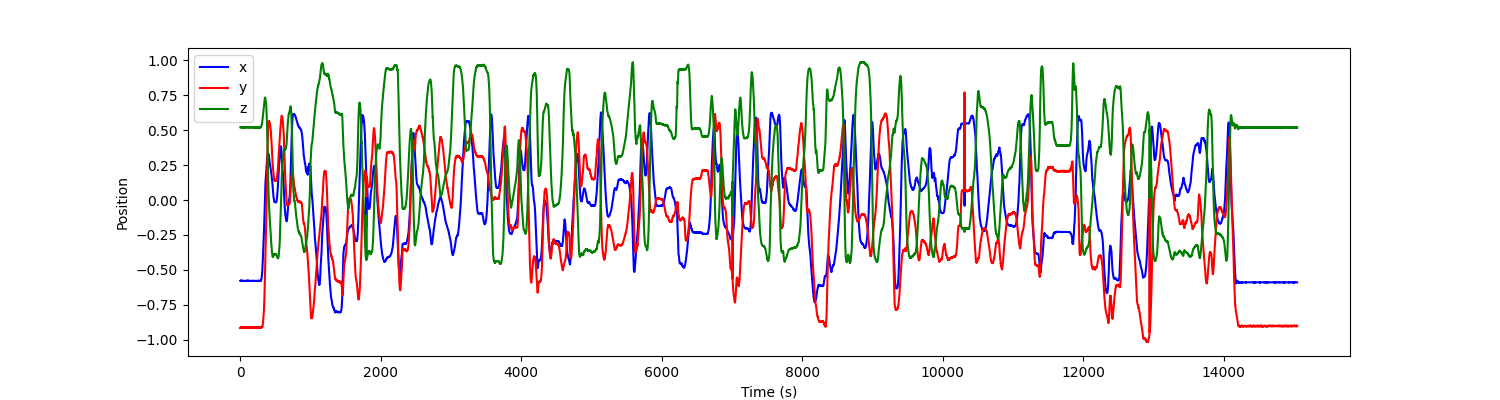

In [22]:
mag = sen_in[0, :, 0]

fig = plt.figure(figsize=(15,4))
plt.plot(time_arr, mag[:, 0], c="blue", label="x")
plt.plot(time_arr, mag[:, 1], c="red", label="y")
plt.plot(time_arr, mag[:, 2], c="green", label="z")
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position")
# plt.ylim(ymax = 0.75, ymin = -1.25)
plt.show()

<IPython.core.display.Javascript object>


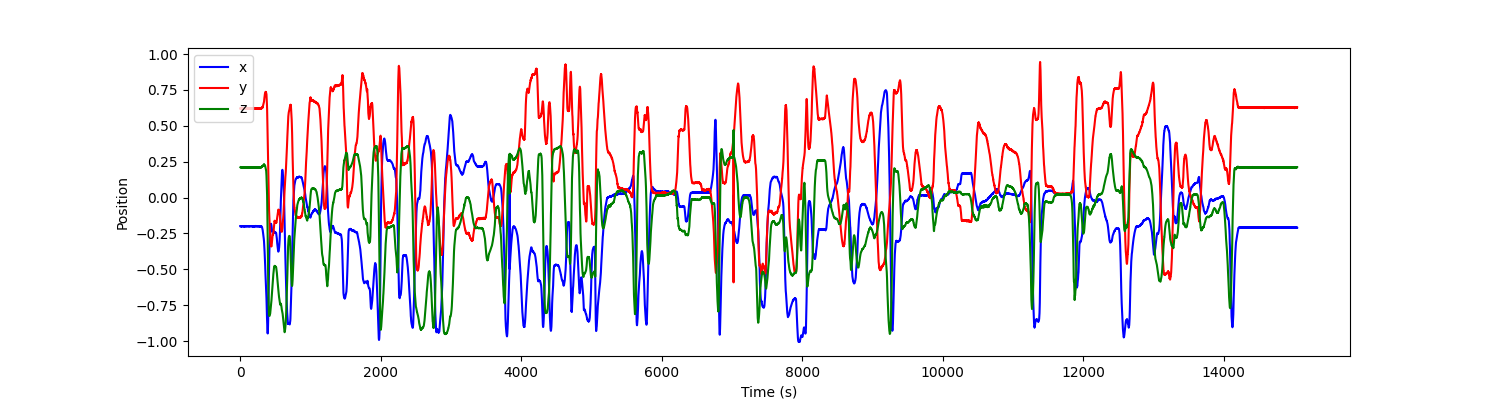

In [23]:
mag = sen_in[0, :, 1]

fig = plt.figure(figsize=(15,4))
plt.plot(time_arr, mag[:, 0], c="blue", label="x")
plt.plot(time_arr, mag[:, 1], c="red", label="y")
plt.plot(time_arr, mag[:, 2], c="green", label="z")
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position")
# plt.ylim(ymax = 0.75, ymin = -1.25)
plt.show()

<IPython.core.display.Javascript object>


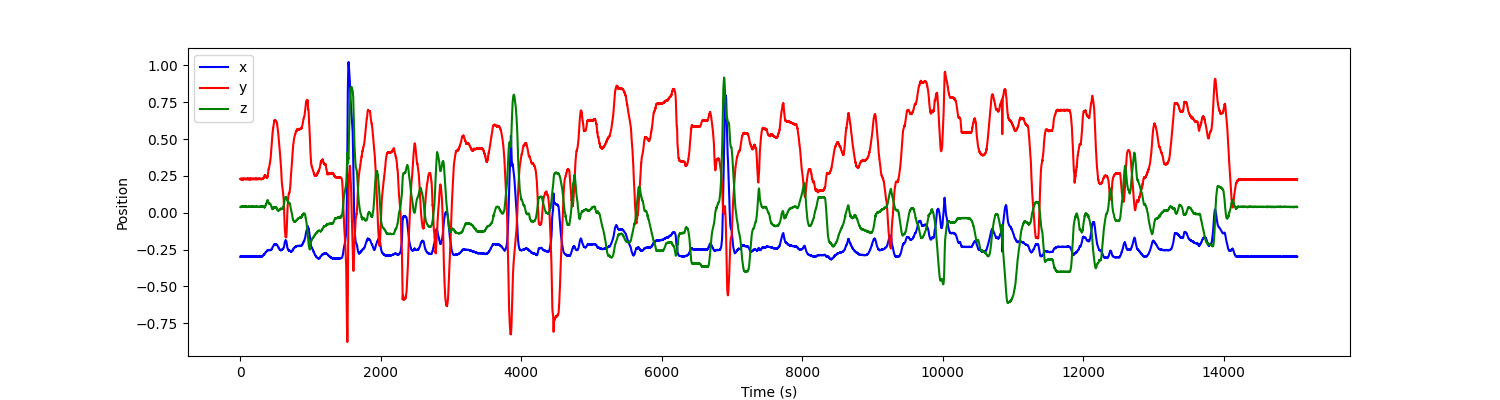

In [24]:
mag = sen_in[0, :, 2]

fig = plt.figure(figsize=(15,4))
plt.plot(time_arr, mag[:, 0], c="blue", label="x")
plt.plot(time_arr, mag[:, 1], c="red", label="y")
plt.plot(time_arr, mag[:, 2], c="green", label="z")
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position")
# plt.ylim(ymax = 0.75, ymin = -1.25)
plt.show()

<IPython.core.display.Javascript object>


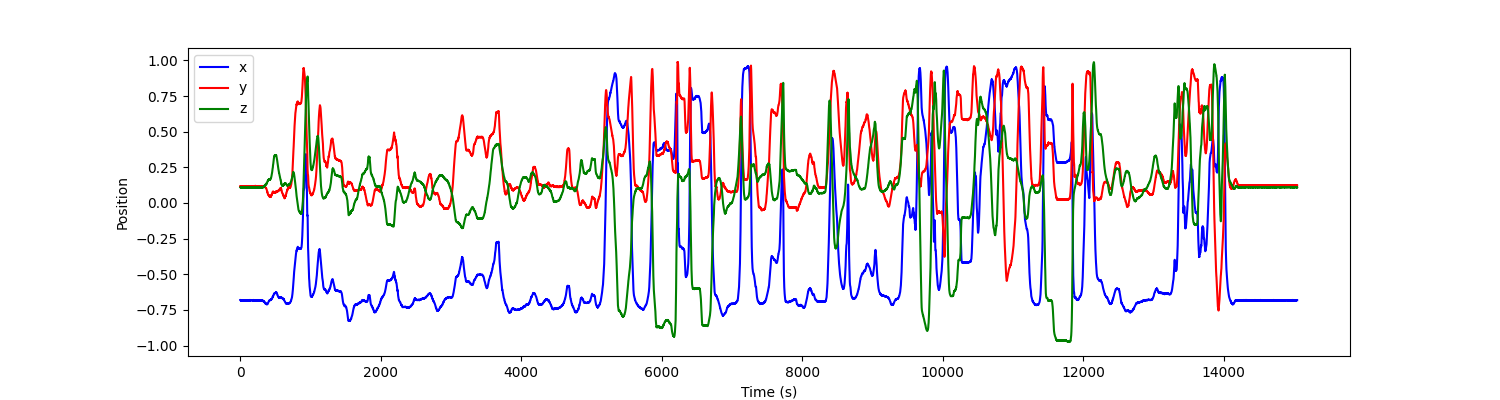

In [25]:
mag = sen_in[0, :, 3]

fig = plt.figure(figsize=(15,4))
plt.plot(time_arr, mag[:, 0], c="blue", label="x")
plt.plot(time_arr, mag[:, 1], c="red", label="y")
plt.plot(time_arr, mag[:, 2], c="green", label="z")
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position")
# plt.ylim(ymax = 0.75, ymin = -1.25)
plt.show()

<IPython.core.display.Javascript object>


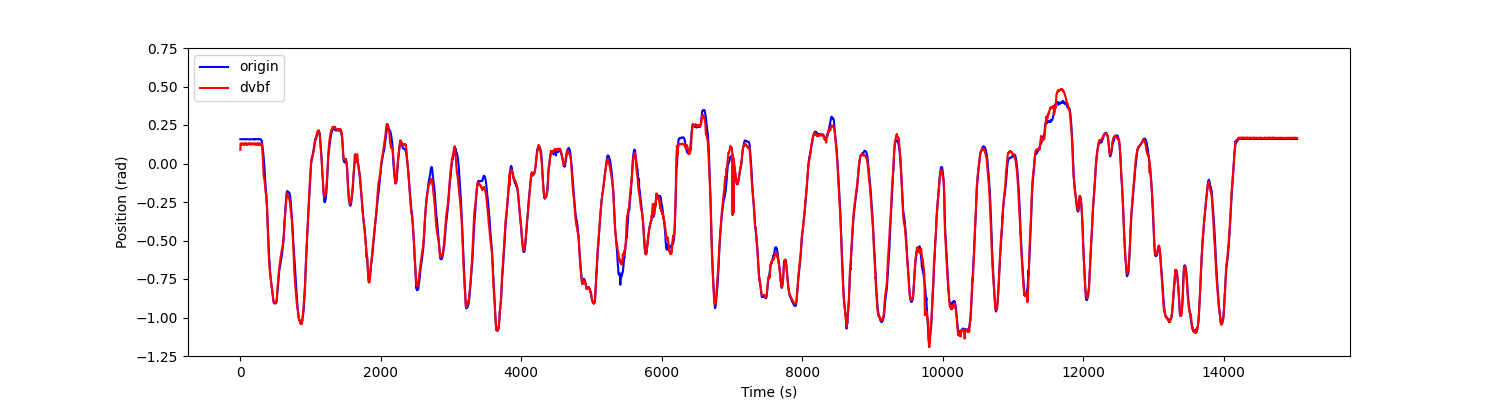

In [26]:
fig = plt.figure(figsize=(15,4))
plt.plot(time_arr, euler_gt[:, 0], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 0], c="red", label="dvbf")
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 0.75, ymin = -1.25)
plt.show()

<IPython.core.display.Javascript object>


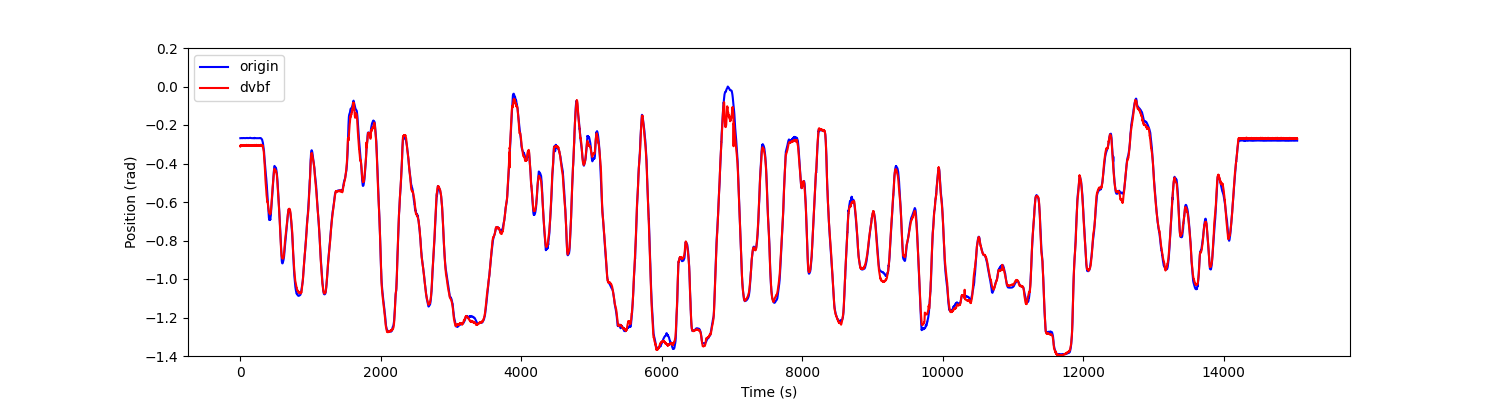

In [27]:
fig = plt.figure(figsize=(15,4))
plt.plot(time_arr, euler_gt[:, 1], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 1], c="red", label="dvbf")
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 0.2, ymin = -1.4)
plt.show()

<IPython.core.display.Javascript object>


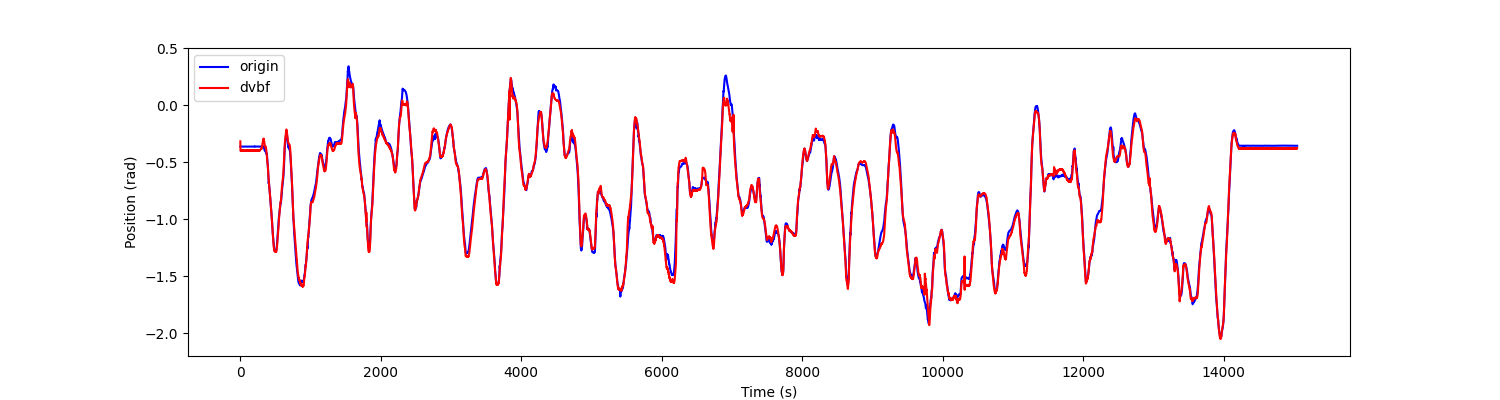

In [28]:
fig = plt.figure(figsize=(15,4))
plt.plot(time_arr, euler_gt[:, 2], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 2], c="red", label="dvbf")
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 0.5, ymin = -2.2)
plt.show()